In [136]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind , pearsonr , chi2,chi2_contingency

from sklearn.linear_model import LinearRegression 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import model_selection

from collections import Counter
import re


import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer

import plotly.express as px
import plotly.graph_objects as go

In [2]:
#Paramètres généraux pour les graphiques
couleur_axes="dimgray"
couleur_texte="darkslategray"
couleur_boite="gainsboro"


In [30]:
#Lecture du fichier issu du webscraping

sélection_café=pd.read_csv(r"C:\data\café_2\TOP-RATED_COFFEES.csv")


In [31]:
#Décision 1 :
#Les colonnes note_acidité_structure, note_avec_lait sont supprimées.Les 2 variables ne sont plus côtés dans les années récentes

sélection_café=sélection_café.drop(["note_acidité_structure","note_avec_lait"],axis=1)

#Les lignes avec des données manquantes sur les variables importantes sont supprimées.
#Priorité : origine café ,niveau torréfaction,cotation,note arôme,note saveur, puis les informations sous forme de texte
sélection_café=sélection_café.dropna(axis=0,how="any",subset=["origine_café","niveau_torréfaction","cotation","note_arôme",
                                                   "note_saveur", "jugement","notes","conclusion"])


#Certains cafés ont pour origine_café la valeur "Not disclosed"
sélection_café=sélection_café[sélection_café["origine_café"]!="Not disclosed"]

#Traitement des types de données: colonne de date
sélection_café["date_test"]=pd.to_datetime(sélection_café["date_test"])

#Remplacement de cette colonne par 2 colonnes année et mois
sélection_café["année_test"]=sélection_café["date_test"].dt.year
sélection_café["mois_test"]=sélection_café["date_test"].dt.month_name(locale="French")

sélection_café=sélection_café.drop(["date_test"],axis=1)

In [32]:
#Ajout des différentes varaibles ( cf notebook café_2_analyse)

#Ajout d'une colonne pays_origine
#Traitement mis au point itérativement: traitement regex puis traitements ad-hoc des cas particuliers

#Traitement regex
sélection_café["pays_origine"]=sélection_café["origine_café"].apply(lambda x: x.split(",")[-1])
sélection_café["pays_origine"]=sélection_café["pays_origine"].apply(lambda x:x.strip())
sélection_café["pays_origine"]=sélection_café["pays_origine"].apply(lambda x :re.compile('.*o.th.*\s').sub("",x))
sélection_café["pays_origine"]=sélection_café["pays_origine"].apply(lambda x :re.compile('.*estern.*\s').sub("",x))
sélection_café["pays_origine"]=sélection_café["pays_origine"].apply(lambda x :re.compile('.*rovince.*\s').sub("",x))
sélection_café["pays_origine"]=sélection_café["pays_origine"].apply(lambda x :re.compile('.*entral.*\s').sub("",x))
sélection_café["pays_origine"]=sélection_café["pays_origine"].apply(lambda x :re.compile('.*of\s').sub("",x))
sélection_café["pays_origine"]=sélection_café["pays_origine"].apply(lambda x :re.compile('.*the\s').sub("",x))
sélection_café["pays_origine"]=sélection_café["pays_origine"].apply(lambda x :re.compile('and').sub(";",x))
sélection_café["pays_origine"]=sélection_café["pays_origine"].apply(lambda x :re.compile('.*El.*\s').sub("",x))

#Cas particuliers  à traiter "à la main"
for i in sélection_café.index:
    test=sélection_café["pays_origine"][i]
    if test=="Apaneca Ilamatepec mountain range":
        sélection_café["pays_origine"][i]='Salvador'
    if test=='Huehuetenango':  
         sélection_café["pays_origine"][i]='Guatemala'
    if (test=='Gedeo Zone')| (test=='southern'):  
         sélection_café["pays_origine"][i]='Ethiopia' 
    if test=='Rica':  
         sélection_café["pays_origine"][i]='Costa Rica'
    if test[0:3]=="Haw":  
         sélection_café["pays_origine"][i]="Hawaii"   
    if test=='Kenya Gatugi AB':         
         sélection_café["pays_origine"][i]="Kenya"    
            
#Décision de renommer "Salvador" en "El Salvador"
for i in sélection_café.index:
    test=sélection_café["pays_origine"][i]
    if test=="Salvador":
        sélection_café["pays_origine"][i]='El Salvador'

#Ajout d'une variable type_origine pour selon que l'on a un mélange ( les "Blend"s") nou un pure origine
sélection_café["type_origine"]=sélection_café["pays_origine"].apply(lambda x:len(x.split(";")))
sélection_café["type_origine"]=sélection_café["type_origine"].apply(lambda x :"mélange" if x >1  else "pure origine") 

#2 corrections : les origines "Africa" et "America"  sont modifiées reclassées en mélange            
for i in sélection_café.index:
    test=sélection_café["pays_origine"][i]
    if (test=="Africa") | (test=="America"):
        sélection_café["type_origine"][i]= "mélange"
        
        
#Décision de travailler uniquement avec les cafés pure origine
sélection_café=sélection_café[sélection_café["type_origine"]=="pure origine"].reset_index(drop=True)
sélection_café=sélection_café.drop(["type_origine"],axis=1)
        

#Ajout d'une colonne  pays_torréfaction
#Traitement particulier de Whashington , pour ne pas confondre l'état de Washington (Seatle,  ..)et la capitale Whashington DC
#dans les traitements ultérieurs
sélection_café["lieu_torréfaction"]=sélection_café["lieu_torréfaction"].apply(lambda x :re.compile(',\sD.C.').sub("DC",x))
sélection_café["lieu_torréfaction"]=sélection_café["lieu_torréfaction"].apply(lambda x :re.compile(',\sDC').sub("DC",x))
sélection_café["pays_torréfaction"]=sélection_café["lieu_torréfaction"].apply(lambda x: x.split(",")[-1])
sélection_café["pays_torréfaction"]=sélection_café["pays_torréfaction"].apply(lambda x :re.compile('.*of\s').sub("",x))
sélection_café["pays_torréfaction"]=sélection_café["pays_torréfaction"].apply(lambda x :re.compile('\.').sub("",x))
sélection_café["pays_torréfaction"]=sélection_café["pays_torréfaction"].apply(lambda x :re.compile('.*El.*\s').sub("",x))
sélection_café["pays_torréfaction"]=sélection_café["pays_torréfaction"].apply(lambda x :re.compile('MI').sub("Mi",x))
sélection_café["pays_torréfaction"]=sélection_café["pays_torréfaction"].apply(lambda x :re.compile('niaa').sub("nia",x))
sélection_café["pays_torréfaction"]=sélection_café["pays_torréfaction"].apply(lambda x:x.strip())

#Quelques traitements spécifiqyes
for i in sélection_café.index:
    test=sélection_café["pays_torréfaction"][i]
    if test[0:3]=="Haw":  
         sélection_café["pays_torréfaction"][i]="Hawaii"
    if test=="Sacr":  
         sélection_café["pays_torréfaction"][i]="California"  
            
#et vérification du cas Washington

#Ajout d'une variable supplémentaire ciblée sur les cafés avec une cotation >94

sélection_café["cotation>94"]=sélection_café["cotation"].apply(lambda x: 1 if x >94 else 0)
           

In [6]:
#Jusqu'ici ; il s'agit d'une simple resconstitution des données telles qu'elles étaient en fin 
#du notebook café_2_analyse

In [7]:
#Travail sur le jugement de chaque café

In [33]:
#Tokénisation par phrase - on conserve la première phrase du jugement 
#Elle contient les qualificatifs attribués à chaque café.
sélection_café["jugement"]=sélection_café["jugement"].apply(lambda x :re.compile(';').sub(".",x))
sélection_café["jugement"]=sélection_café["jugement"].apply(lambda x:x.lower())
"""
sélection_café["jugement"]=sélection_café["jugement"].apply(lambda x:sent_tokenize(x))
sélection_café["nb_jugement"]=sélection_café["jugement"].apply(lambda x: len(x))
sélection_café["jugement_1"]=sélection_café["jugement"].apply(lambda x:x[0])

"""

'\nsélection_café["jugement"]=sélection_café["jugement"].apply(lambda x:sent_tokenize(x))\nsélection_café["nb_jugement"]=sélection_café["jugement"].apply(lambda x: len(x))\nsélection_café["jugement_1"]=sélection_café["jugement"].apply(lambda x:x[0])\n\n'

In [130]:
mots_filtrés=set(stopwords.words("english"))
mots_filtrés.update(["authority","authoritative","cup","cups","coffee","aroma","aromas","aromatic","hint","big","high","espresso",
                    "black","complete","profile","flavor","like","resonant","finish","mouthfeel","sandalwood","structure",
                    "nib","star","small","red","short","milk",",",".",";",":","]","[","(",")","{","}"])

In [131]:
#Traitement manuel itératif intégré après inspection du top 50 de la liste des qualificatifs uniques
liste_qualificatifs=[]
liste_suffixes=["toned","driven","forward","centered","bright","like"]
sélection_café["qualificatifs"]=["" for i in sélection_café.index]
for i in sélection_café.index:
    liste_test=[]
    test=nltk.pos_tag(word_tokenize(sélection_café["jugement"][i]))
    for mot , type in test:
        if mot not in mots_filtrés:
            mot2=""
            if(type=='JJ') | (type=='NN'):
                
                if mot[-1]=='-':
                    mot=mot[0:-1]
                if mot=="high-toned":
                    mot="hightoned"
                if mot=="multi-layered":
                    mot="multilayered" 
                if mot=="fresh-cut":
                    mot="freshcut"
                if mot=="star-jasmine":
                    mot="jasmine"
                #Traitement des autres cas avec tiret
                if re.compile("-").search(mot):
                    mot1=re.compile("-").split(mot)[0]
                    mot2=re.compile("-").split(mot)[1]
                    if mot2 in liste_suffixes:
                        mot2=""
                    #   
                    mot=mot1
                    
                #Traitements spécifiques intégrés
                #mot=re.compile('complex*').sub("complex",mot)
                if mot[0:8]=="chocolat":
                    mot=mot[0:8]
                if mot[0:7]=="complex":
                    mot=mot[0:7] 
                if mot[-2:]=="ly" :
                    mot=mot[0:-2]  
                if (mot[-2:] in ["ty","sy"]) & (mot!="acidity"):
                    mot=mot[0:-1]  
                if mot=="acidity":
                    mot="acid"    
                if mot=="spice":
                    mot="spicy"
                if mot=="cocoa":
                    mot="cacao"    
                #test
                if mot=="milk":
                    print(i)
                #Ajouts aux listes
                liste_test.append(mot)
                liste_qualificatifs.append(mot)
                if mot2!="":
                    liste_test.append(mot2)
                    liste_qualificatifs.append(mot2)
               
    #Ecriture dans le dataframe
    sélection_café["qualificatifs"][i]=liste_test


In [145]:
#Liste des valeurs uniques de qualificatifs
liste_qual_unic=np.unique(liste_qualificatifs)
print(len(liste_qual_unic))
print(len(liste_qualificatifs))

1070
29404


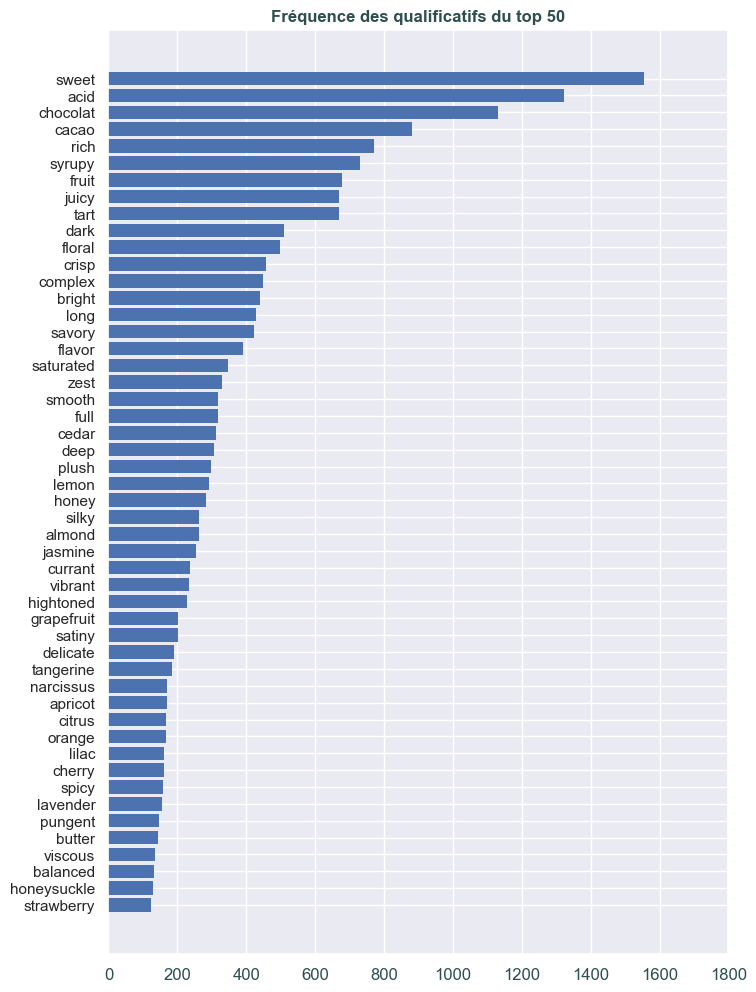

In [154]:
#Histogramme des qualificatifs
top=50
dico_qualificatifs=Counter(liste_qualificatifs)
qualificatifs=[m[0] for m in dico_qualificatifs.most_common(top)]
freq=[m[1] for m in dico_qualificatifs.most_common(top)]
df=pd.DataFrame({"Qualificatif":qualificatifs,"Frequence":freq})
df=df.sort_values(by="Frequence",ascending=True)
fig,ax=plt.subplots(figsize=(8,12))
bars = plt.barh(df["Qualificatif"], 
                df["Frequence"], 
                #color = ['lightgray', 'lightgray', 'lightgray', 'lightgray', "black"], # color for bars
                edgecolor='none')

#sns.barplot(ax=ax,x=qualificatifs,y=freq,color="royalblue",orient="h")
ax.set_xlim([0,1800])
#ax.set_xticklabels(labels=qualificatifs,rotation=90,color=couleur_texte,size=12)
ax.set_xticklabels(labels=[0,200,400,600,800,1000,1200,1400,1600,1800],color=couleur_texte,size=12)
ax.set_title(f"Fréquence des qualificatifs du top {top}",color=couleur_texte,size=12,weight="bold");

fig.savefig("café_3_graphe1")

In [144]:
qualificatifs

['sweet',
 'acid',
 'chocolat',
 'cacao',
 'rich',
 'syrupy',
 'fruit',
 'juicy',
 'tart',
 'dark',
 'floral',
 'crisp',
 'complex',
 'bright',
 'long',
 'savory',
 'flavor',
 'saturated',
 'zest',
 'smooth',
 'full',
 'cedar',
 'deep',
 'plush',
 'lemon',
 'honey',
 'silky',
 'almond',
 'jasmine',
 'currant',
 'vibrant',
 'hightoned',
 'grapefruit',
 'satiny',
 'delicate',
 'tangerine',
 'apricot',
 'narcissus',
 'citrus',
 'orange',
 'lilac',
 'cherry',
 'spicy',
 'lavender',
 'pungent',
 'butter',
 'viscous',
 'balanced',
 'honeysuckle',
 'strawberry']

In [134]:
#stats rapides sur les qualificatifs
print ("Nombre total de qualificatifs :",len(liste_qualificatifs))
print("Nombre de qualificatifs distincts :",len(liste_qual_unic))


#Quelle proportion des qualificatifs repréente le top 20 des mots
top_liste=np.sum(freq)/len(liste_qualificatifs)
print (f"Proportion du top {top} dans le nombre total de qualificatifs :{top_liste:.3%}")

top_unique=top/len(liste_qual_unic)
print(f"Le top {top} représente :{top_unique:.3%} de la liste des qualificatifs")


#il faut 322 qualificatifss soit 17% de la liste pour couvrir 80% des mots
#895 qualificatifs avec une frequence supérieure à 1


Nombre total de qualificatifs : 29404
Nombre de qualificatifs distincts : 1072
Proportion du top 50 dans le nombre total de qualificatifs :65.236%
Le top 50 représente :4.664% de la liste des qualificatifs


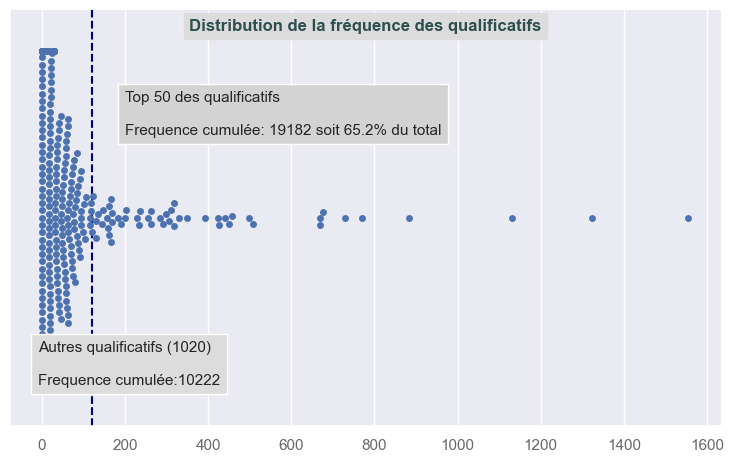

In [140]:
#Graphique d'ensemble des fréquences d'apparition des qualificatifs dans les jugements

qualificatifs=[m[0] for m in dico_qualificatifs.most_common()]
frequences=[m[1] for m in dico_qualificatifs.most_common()]

#Constitution d'un dataframe simple à manipuler , ordonné par fréquence décroissante
df_freq=pd.DataFrame({"qualificatif":qualificatifs,"frequence":frequences})
df_freq=df_freq.sort_values(by="frequence",ascending=False)


#Graphiques
fig1=sns.catplot(data=df_freq,x="frequence",kind="swarm",aspect=1.5)
plt.title("Distribution de la fréquence des qualificatifs", size=12,color=couleur_texte,weight="bold",pad=-15,
         backgroundcolor=couleur_boite)
fig1.refline(x=df_freq.iloc[top,1],color="navy")

plt.xticks(color=couleur_axes)
plt.xlabel("");

texte1=f"Top {top} des qualificatifs "
texte2="Frequence cumulée: "+str(df_freq.iloc[:top,1].sum())+f" soit {top_liste:.1%} du total"

plt.text(200,-0.2,texte1+"\n\n"+texte2,size=11,weight="light",
         bbox={'facecolor': 'lightgrey', 'alpha': 1, 'pad': 5} );

texte3=f"Autres qualificatifs ({df_freq.iloc[top:,0].count()})"
texte4=f"Frequence cumulée:{df_freq.iloc[top:,1].sum()}"


plt.text(-10,+0.4,texte3+"\n\n"+texte4,size=11,
         bbox={'facecolor': couleur_boite, 'alpha': 1, 'pad': 5} );


#Image
fig1.savefig("café_3_graphe2")  



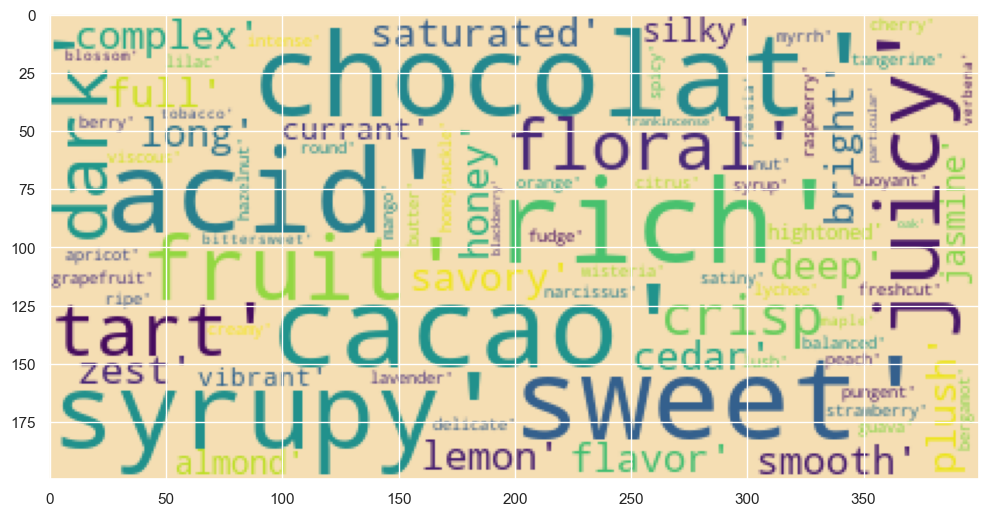

In [156]:
#wordcloud
wc=WordCloud(background_color="wheat",max_words=100,max_font_size=50)
#si utilisation de tokens alors prendre str(tokens)
wc.generate(str(Counter(liste_qualificatifs).most_common(80)))  #rappel liste optenue via Counter , most_common
plt.figure(figsize=(12,8))
plt.imshow(wc)
plt.show;


#Image
image=wc.to_image()
image.save("café_3_graphe3"+".png")  

In [36]:
#FIN
